# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init('D:\SPARK\spark-2.3.2-bin-hadoop2.7')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

load the json to data according to the function

In [ ]:
data = spark.read.json('Data/Posts.json')
data.take(5)

We can see that both questions and answers have their own unique values. For questions, they have meaningful ViewCount values and for answers, they have meaningful ParentId values. We split the data to question and answer according to the criteria.

In [3]:
question=data.filter('ViewCount>=0') \
                    .select('id','CreationDate','PostTypeId', 'Score','Tags', 'Title','ViewCount')
question.show()

+-------+--------------------+----------+-----+--------------------+--------------------+---------+
|     id|        CreationDate|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------+--------------------+----------+-----+--------------------+--------------------+---------+
|4020437|2010-10-26T03:17:...|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|4020438|2010-10-26T03:18:...|         1|    0|<javascript><html...|Why can only my m...|       62|
|4020445|2010-10-26T03:21:...|         1|    0|<c++><visual-stud...|Communicating ove...|     1170|
|4020449|2010-10-26T03:21:...|         1|    0|<c#><textbox><fil...|C# Text Box File ...|      845|
|4020450|2010-10-26T03:21:...|         1|    0|<php><wordpress><...|PHP image grab wh...|      761|
|4020453|2010-10-26T03:22:...|         1|    4|<objective-c><del...|Objective C - Str...|     1091|
|4020456|2010-10-26T03:23:...|         1|    2|       <c><pointers>|Changing pointer ...|     4143|


In [4]:
answer=data.filter('ParentId>=0') \
                    .select('id','CreationDate','ParentId','PostTypeId', 'Score')
answer.show()

+-------+--------------------+--------+----------+-----+
|     id|        CreationDate|ParentId|PostTypeId|Score|
+-------+--------------------+--------+----------+-----+
|4020440|2010-10-26T03:19:...| 4020214|         2|    1|
|4020441|2010-10-26T03:19:...| 3938154|         2|    0|
|4020443|2010-10-26T03:20:...| 4020419|         2|  324|
|4020444|2010-10-26T03:20:...| 4020433|         2|    0|
|4020447|2010-10-26T03:21:...| 4020433|         2|    1|
|4020448|2010-10-26T03:21:...| 4020437|         2|    1|
|4020451|2010-10-26T03:21:...| 4020382|         2|    2|
|4020452|2010-10-26T03:22:...| 4020433|         2|    7|
|4020454|2010-10-26T03:22:...| 4020433|         2|    2|
|4020455|2010-10-26T03:22:...| 1175258|         2|    5|
|4020458|2010-10-26T03:23:...| 4010166|         2|    1|
|4020461|2010-10-26T03:23:...| 4006559|         2|    0|
|4020462|2010-10-26T03:24:...| 4018842|         2|    2|
|4020463|2010-10-26T03:25:...| 4020374|         2|    7|
|4020466|2010-10-26T03:27:...| 

1. How many questions have been asked on StackOverflow?

In [5]:
num_question=question.count()
print(str(num_question)+ ' questions have been asked on StackOverflow')

15647060 questions have been asked on StackOverflow


2. How many answers have been given?

In [6]:
num_answer=answer.count()
print(str(num_answer)+' answers have been given')

25192772 answers have been given


3. What is the percentage of questions with a score of 0?

In [7]:
question_score_0=question[question['score']==0]
num_question_score_0 = question_score_0.count()
temp_per= 100 * num_question_score_0 / num_question
print (str(temp_per)+'% of questions have scores of 0')

46.54365740273253% of questions have scores of 0


**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

Since we cannot directly turn the spark dataframe to pandas dataframe due to its extemely large amount, we first try to merge 'Tags' value and counts of each unique value. This step can reduce the space to some degree. In this step, we do not split the 'Tags' values into several tags.

In [4]:
temp_count=question.groupBy("Tags")\
                                    .agg(count("*").alias("count"))\
                                    .sort(desc("count"))
temp_count.show()

+--------------------+------+
|                Tags| count|
+--------------------+------+
|           <android>|100395|
|        <javascript>| 76988|
|<javascript><jquery>| 76753|
|               <php>| 70538|
|              <java>| 69644|
|            <python>| 61394|
|         <html><css>| 59491|
|            <jquery>| 54102|
|                <c#>| 49569|
|             <mysql>| 47423|
|        <php><mysql>| 45929|
|               <c++>| 41030|
|                 <r>| 37287|
|     <java><android>| 31556|
|<javascript><jque...| 29602|
|        <mysql><sql>| 27425|
|                 <c>| 25175|
|<javascript><jque...| 24921|
|         <angularjs>| 24814|
|  <javascript><html>| 24390|
+--------------------+------+
only showing top 20 rows



We turn the merged dataframe to rdd to implement the '>' split function to split the each 'Tags' value to several single tags (from one string to arrays containing several tag strings). Since we use '>' to split the strings, each tags inside has a form like '<java'. Later, we can use explode function to sepearate each array.

In [5]:
temp_rdd = temp_count.rdd.map(lambda r: Row(Tags=r[0].split('>')[:-1], count=r[1]))
temp_rdd.take(5)

[Row(Tags=['<android'], count=100395),
 Row(Tags=['<javascript'], count=76988),
 Row(Tags=['<javascript', '<jquery'], count=76753),
 Row(Tags=['<php'], count=70538),
 Row(Tags=['<java'], count=69644)]

We use the explode function to seperate a 'Tags' value of each row to several single tag values with corresponding several rows.

In [6]:
from pyspark.sql.functions import explode

temp_tags = spark.createDataFrame(temp_rdd)
temp_tags=temp_tags.withColumn("Tags", explode(temp_tags.Tags))
temp_tags.show(5)

+-----------+------+
|       Tags| count|
+-----------+------+
|   <android|100395|
|<javascript| 76988|
|<javascript| 76753|
|    <jquery| 76753|
|       <php| 70538|
+-----------+------+
only showing top 5 rows



Again, we use the '<'  split opeation to turn the form like '<java' to 'java'.

In [7]:
temp_rdd=temp_tags.rdd.map(lambda r: Row(Tags=r[0][1:], count=r[1]))
question_tags = spark.createDataFrame(temp_rdd)
question_tags.show(5)

+----------+------+
|      Tags| count|
+----------+------+
|   android|100395|
|javascript| 76988|
|javascript| 76753|
|    jquery| 76753|
|       php| 70538|
+----------+------+
only showing top 5 rows



We use the groupBy function to aggregate the counts of each unque 'Tags' value to get the count value of each tag. We also use the decending sort to get the count values from the largest to smallest.

In [8]:
question_tags_count = question_tags.groupBy("Tags")\
                                    .agg(sum("count").alias("sum"))\
                                    .sort(desc("sum"))
question_tags_count.show()

+-------------+-------+
|         Tags|    sum|
+-------------+-------+
|   javascript|1585495|
|         java|1352735|
|           c#|1172492|
|          php|1136082|
|      android|1088811|
|       python| 954401|
|       jquery| 886982|
|         html| 725289|
|          ios| 551843|
|          c++| 536267|
|          css| 520821|
|        mysql| 499795|
|          sql| 436051|
|      asp.net| 326270|
|ruby-on-rails| 290977|
|  objective-c| 272992|
|         .net| 259404|
|            c| 255644|
|       arrays| 251753|
|    angularjs| 249378|
+-------------+-------+
only showing top 20 rows



1. What is the proportion of tags that appear in fewer than 100 questions?

In [10]:
num_tags=question_tags_count.count()
tags_lower_than_100=question_tags_count[question_tags_count['sum']<100].count()
temp_proportion=tags_lower_than_100/num_tags
print(str(temp_proportion)+' of tags that appear in fewer than 100 questions')

0.6797939389364833 of tags that appear in fewer than 100 questions


2. Plot the distribution of the tag counts using an appropriate representation

Now the dataframe does not contain huge space and we can turn the spark dataframe to pandas dataframe. 

In [11]:
question_tags_count_pd=question_tags_count.toPandas()
question_tags_count_pd.head(5)

,Tags,sum
0,javascript,1585495
1,java,1352735
2,c#,1172492
3,php,1136082
4,android,1088811


We use the histogram to plot the distribution of tag counts calculated and use log to make the histogram look better.

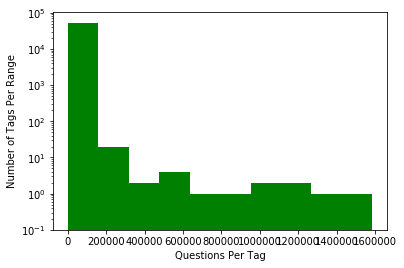

In [12]:
plt.xlabel('Questions Per Tag')
plt.ylabel('Number of Tags Per Range')
_ , _ , _ = plt.hist(question_tags_count_pd['sum'],facecolor='green',histtype='stepfilled',stacked=True,log=True)

3. Plot a bar chart with the number of questions for the 10 most popular tags

Text(0,0.5,'Count of Per Tag')

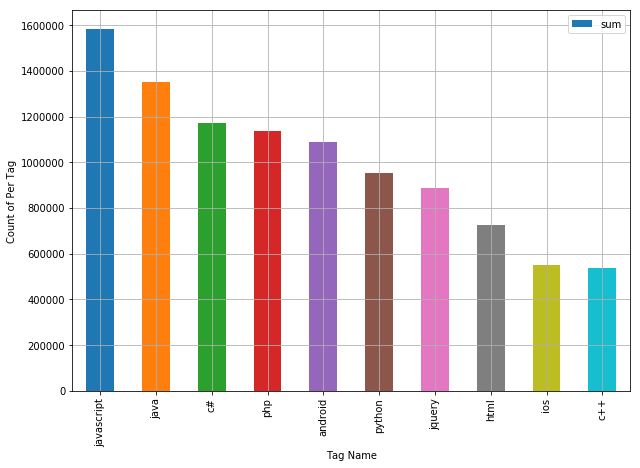

In [13]:
temp_tags_count = question_tags_count_pd.head(10)
p2 = temp_tags_count.plot(kind="bar", x="Tags", y="sum", figsize=(10, 7), grid=True)
p2.set_xlabel("Tag Name")
p2.set_ylabel("Count of Per Tag")

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [14]:
# Add your code and description here

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


In [15]:
# Add your code and description here

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [16]:
see_pyspark=question_tags_count_pd[[tags.endswith('pyspark') for tags in question_tags_count_pd.Tags]]
see_pyspark

,Tags,sum
567,pyspark,10266


In [17]:
from datetime import datetime, date, time, timedelta
question.show(5)

+-------+--------------------+----------+-----+--------------------+--------------------+---------+
|     id|        CreationDate|PostTypeId|Score|                Tags|               Title|ViewCount|
+-------+--------------------+----------+-----+--------------------+--------------------+---------+
|4020437|2010-10-26T03:17:...|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|4020438|2010-10-26T03:18:...|         1|    0|<javascript><html...|Why can only my m...|       62|
|4020445|2010-10-26T03:21:...|         1|    0|<c++><visual-stud...|Communicating ove...|     1170|
|4020449|2010-10-26T03:21:...|         1|    0|<c#><textbox><fil...|C# Text Box File ...|      845|
|4020450|2010-10-26T03:21:...|         1|    0|<php><wordpress><...|PHP image grab wh...|      761|
+-------+--------------------+----------+-----+--------------------+--------------------+---------+
only showing top 5 rows



We turn the dataframe to rdd to split the tags into different signle tags and filter the questions with a tag of 'pyspark'. (since we filter the string by '>', each tag has a form like '<pyspark')

In [18]:
tags_date_rdd=question.rdd.map(lambda r: Row(date=datetime.strptime(r[1][:10],'%Y-%m-%d'),Tags=r[4].split('>')[:-1]))
pyspark_date=tags_date_rdd.filter(lambda r:  '<pyspark' in r[0] )
pyspark_date.take(5)

[Row(Tags=['<python', '<tuples', '<flatten', '<pyspark'], date=datetime.datetime(2015, 2, 18, 0, 0)),
 Row(Tags=['<java', '<python', '<apache-spark', '<pyspark'], date=datetime.datetime(2015, 2, 19, 0, 0)),
 Row(Tags=['<python', '<apache-spark', '<bigdata', '<pyspark'], date=datetime.datetime(2015, 2, 19, 0, 0)),
 Row(Tags=['<amazon-web-services', '<apache-spark', '<ipython', '<pyspark'], date=datetime.datetime(2015, 2, 20, 0, 0)),
 Row(Tags=['<json', '<amazon-s3', '<apache-spark', '<pyspark'], date=datetime.datetime(2015, 2, 23, 0, 0))]

We turn the questions with pyspark tags to pandas dataframe.

In [19]:
pyspark_date_df = spark.createDataFrame(pyspark_date)
pyspark_date_pd=pyspark_date_df.toPandas()
pyspark_date_pd.head(5)

,Tags,date
0,"[<python, <tuples, <flatten, <pyspark]",2015-02-18
1,"[<java, <python, <apache-spark, <pyspark]",2015-02-19
2,"[<python, <apache-spark, <bigdata, <pyspark]",2015-02-19
3,"[<amazon-web-services, <apache-spark, <ipython...",2015-02-20
4,"[<json, <amazon-s3, <apache-spark, <pyspark]",2015-02-23


We sort the dataframe with the ascending of data, for convenience of later distribution statistics.

In [20]:
pyspark_date_raw= pyspark_date_pd[['date','Tags']].sort_values(ascending=True,  by='date')
pyspark_date_raw.reset_index(inplace=True)
pyspark_date_raw=pyspark_date_raw[['date','Tags']]
pyspark_date_raw.head(10)

,date,Tags
0,2014-04-23,"[<python, <apache-spark, <pyspark]"
1,2014-08-07,"[<python, <apache-spark, <hadoop, <pyspark, <y..."
2,2014-10-02,"[<python, <apache-spark, <pyspark, <distribute..."
3,2014-10-18,"[<apache-spark, <apache-spark-sql, <pyspark]"
4,2014-10-24,"[<apache-spark, <nltk, <emr, <textblob, <pyspark]"
5,2014-11-04,"[<python, <apache-spark, <pyspark]"
6,2014-11-12,"[<scala, <apache-spark, <pyspark]"
7,2014-11-15,"[<python, <apache-spark, <pyspark, <rdd]"
8,2014-11-16,"[<python, <apache-spark, <pyspark]"
9,2014-11-18,"[<python, <apache-spark, <mapreduce, <pyspark,..."


As we see, the earliest time is 2014-04-23. We set this date as the first time point of a new pandas dataframe, and get the date of 30-day interval until now. 

In [21]:
pyspark_date_count=pyspark_date_raw[['date']].copy()
now = datetime.now()
i=1
temp_time=pyspark_date_raw['date'][0]
while temp_time < now :
    temp_time=temp_time+ timedelta(days = 30)
    pyspark_date_count['date'][i]=temp_time
    i=i+1
pyspark_date_count=pyspark_date_count[0:i]
pyspark_date_count.head(10)

,date
0,2014-04-23
1,2014-05-23
2,2014-06-22
3,2014-07-22
4,2014-08-21
5,2014-09-20
6,2014-10-20
7,2014-11-19
8,2014-12-19
9,2015-01-18


Now we use a simple for-loop to calculate the count within each 30-day interval. Since the raw dataset and the count dataset both have ascending date values, we just add 1 to the related count value when the date in the raw dataset is within the 30-day interview (later than a date and also earlier than the next date in the count dataset ).

In [22]:
pyspark_date_count['count']=0
for temp_time in pyspark_date_raw['date']:
    for i in range(len(pyspark_date_count)-1):
        if (not(temp_time < pyspark_date_count['date'][i])) and (temp_time < pyspark_date_count['date'][i+1]):
            pyspark_date_count['count'][i]=pyspark_date_count['count'][i]+1
pyspark_date_count

D:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,date,count
0,2014-04-23,1
1,2014-05-23,0
2,2014-06-22,0
3,2014-07-22,1
4,2014-08-21,0
5,2014-09-20,2
6,2014-10-20,6
7,2014-11-19,1
8,2014-12-19,6
9,2015-01-18,11


plot a bar chart according to dataframe we get (usually it's better to use a histogram, but in this case a bar chart looks alike)

Text(0,0.5,'Numbers of Questions with Pyspark Per 30 Days')

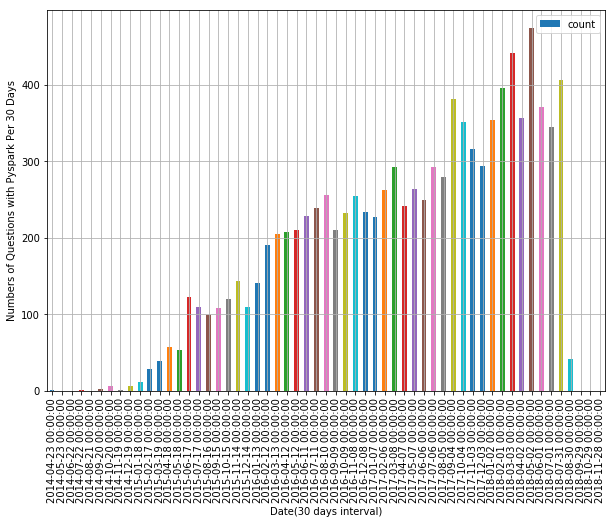

In [23]:
p5 = pyspark_date_count.plot(kind="bar", x="date", y="count", figsize=(10, 7), grid=True)
p5.set_xlabel("Date(30 days interval)")
p5.set_ylabel("Numbers of Questions with Pyspark Per 30 Days")

As time goes, overall more and more questions covering pyspark have been asked despite some little fluctuations.

The ADA course also follows the trend due to the convenience of pyspark :)